In [1]:
import numpy as np
from scipy.stats import sigmaclip
from astropy.table import Table
from photutils.aperture.mask import ApertureMask
from photutils.aperture import aperture_photometry

def aperture_stats_tbl(data, apertures,
                       method='exact', sigma_clip=True):

    # Get the masks that will be used to identify our desired pixels.
    masks = apertures.to_mask(method=method)
    if isinstance(masks, ApertureMask): # fix different return types
        masks = [masks]

    # Compute the stats of pixels within the masks
    aperture_stats = [calc_aperture_mmm(data, mask, sigma_clip)
                      for mask in masks]

    aperture_stats = np.array(aperture_stats)


    # Place the array of the x y positions alongside the stats
    stacked = np.hstack([apertures.positions, aperture_stats])
    # Name the columns
    names = ['X','Y','aperture_mean','aperture_median','aperture_mode',
            'aperture_std', 'aperture_area']
    # Make the table
    stats_tbl = Table(data=stacked, names=names)


    return stats_tbl

def calc_aperture_mmm(data, mask, sigma_clip):
    """Helper function to actually calculate the stats for pixels
        falling within some Photutils aperture mask on some array
        of data.
    """
    cutout = mask.cutout(data, fill_value=np.nan)
    if cutout is None:
        return (np.nan, np.nan, np.nan, np.nan, np.nan)
    else:
        values = cutout * mask.data / mask.data
        values = values[~np.isnan(values)]
        if sigma_clip:
            values, clow, chigh = sigmaclip(values, low=3, high=3)

        mean = np.mean(values)
        median = np.median(values)
        std = np.std(values)

        mode = 3 * median - 2 * mean
        actual_area = (~np.isnan(values)).sum()
        return (mean, median, mode, std, actual_area)
    
def iraf_style_photometry(
        phot_apertures,
        bg_apertures,
        data,
        error_array=None,
        bg_method='mode',
        epadu=1.0):

    if bg_method not in ['mean', 'median', 'mode']:
        raise ValueError('Invalid background method, choose either \
                          mean, median, or mode')

    phot = aperture_photometry(data, phot_apertures, error=error_array)
    bg_phot = aperture_stats_tbl(data, bg_apertures, sigma_clip=True)

    if callable(phot_apertures.area):        # Handle photutils change
        ap_area = phot_apertures.area()
    else:
        ap_area = phot_apertures.area
    bg_method_name = 'aperture_{}'.format(bg_method)

    flux = phot['aperture_sum'] - bg_phot[bg_method_name] * ap_area

    # Need to use variance of the sources
    # for Poisson noise term in error computation.
    #
    # This means error needs to be squared.
    # If no error_array error = flux ** .5
    if error_array is not None:
        flux_error = compute_phot_error(phot['aperture_sum_err']**2.0,
                                        bg_phot, bg_method, ap_area,
                                        epadu)
    else:
        flux_error = compute_phot_error(flux, bg_phot,
                                        bg_method, ap_area, epadu)

    mag = -2.5 * np.log10(flux)
    mag_err = 1.0857 * flux_error / flux

    # Make the final table
    X, Y = phot_apertures.positions.T
    stacked = np.stack([X, Y, flux, flux_error, mag, mag_err], axis=1)
    names = ['X', 'Y', 'flux', 'flux_error', 'mag', 'mag_error']

    final_tbl = Table(data=stacked, names=names)
    return final_tbl

def compute_phot_error(
        flux_variance,
        bg_phot,
        bg_method,
        ap_area,
        epadu=1.0):
    """Computes the flux errors using the DAOPHOT style computation"""
    bg_variance_terms = (ap_area * bg_phot['aperture_std'] ** 2. ) \
                        * (1. + ap_area/bg_phot['aperture_area'])
    variance = flux_variance / epadu + bg_variance_terms
    flux_error = variance ** .5
    return flux_error

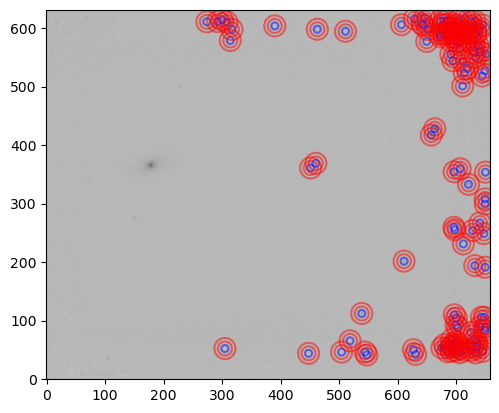

        X                  Y                  flux            flux_error             mag              mag_error      
------------------ ------------------ ------------------- ------------------ ------------------- --------------------
 547.5550412085056  41.08391755911343   63.39920028979168 57.754097689088645  -4.505209449439306   0.9890286245635793
  630.886024931199 42.161140308661196   353.9394323124459  62.24647118004848  -6.372322374958504  0.19093943084736714
447.91300520973175 43.877680378298386 -12.252341537464597  57.37612384879178                 nan   -5.084192068279849
  706.527579408013 44.909868311246086  108.18236038314049  89.28760047381377 -5.0853911322222665   0.8960753628511788
 733.6911702834989 44.677310189336026  107.41191069621095   95.0940023304195  -5.077631105243837   0.9611928291838725
 504.3743929899665  45.97126744544735  -84.67967843169805 56.302700318076205                 nan  -0.7218714438628929
 544.7577255521087  46.11293281339473   7.06715654365993

C:\Users\ranvi\AppData\Local\Temp\ipykernel_20712\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data
C:\Users\ranvi\AppData\Local\Temp\ipykernel_20712\3476141969.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


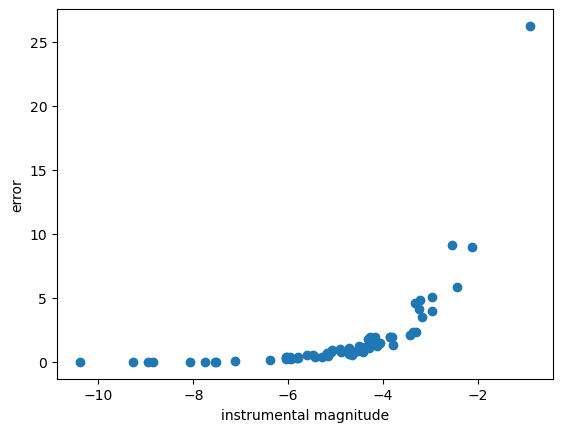

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Number of results: 49


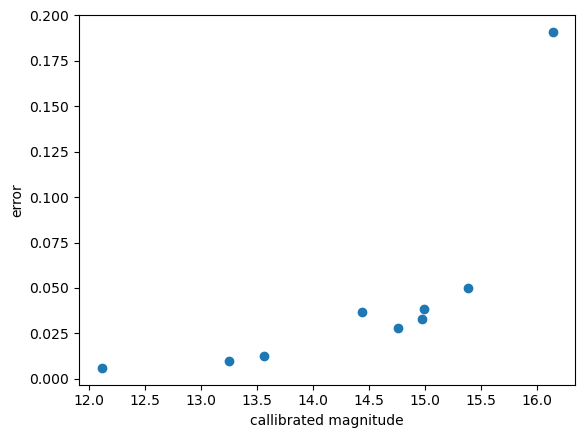

C:\Users\ranvi\AppData\Local\Temp\ipykernel_20712\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(22.51315593377146, 0.12014264370449072, 16.8174236781605, 0.2208660457374188)

In [4]:
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std
from photutils.aperture import CircularAnnulus, CircularAperture, ApertureStats
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.io import fits
from astropy.wcs import WCS
from astroquery.mast import Catalogs
from astroquery.vizier import Vizier
from astropy import coordinates
from astropy import units as u
from astropy.table import QTable
from astropy.stats import sigma_clip
from numpy import random
from photutils.utils import calc_total_error


#Finding Instrumental Mag
def AvgZP(filename, radius, gain, fil):
    hdul = fits.open(filename+".fits")
    image = hdul[0].data
    hdul.close()

    bkg_sigma = mad_std(image)
    daofind = DAOStarFinder(fwhm=4.0, threshold = 5 * bkg_sigma)
    s = daofind(image)
    #s = s[s['xcentroid']>80]
    #s = s[s['xcentroid']<700]
    #s = s[s['ycentroid']>80]
    #s = s[s['ycentroid']<520]
    s = s[s['xcentroid']>260]
    s = s[s['xcentroid']<855]
    s = s[s['ycentroid']>40]
    s = s[s['ycentroid']<670]


    positions = np.transpose((s['xcentroid'], s['ycentroid']))


    circular_apertures = CircularAperture(positions, r=radius)
    annulus_apertures = CircularAnnulus(positions, r_in = 2*radius, r_out = 3*radius) 
    
    norm = simple_norm(image, 'sqrt')
    plt.imshow(image, cmap='gray_r', origin = 'lower', norm = norm)
    circular_apertures.plot(color = 'blue', lw=1.5, alpha = 0.5)
    annulus_apertures.plot(color = 'red', lw = 1.5, alpha = 0.5)
    plt.show()


    result = iraf_style_photometry(circular_apertures, annulus_apertures, image, bg_method='mode', epadu=gain*20)
    print(result)

    #plotting instrumental mag and error

    mag_inst = result['mag']
    mag_inst_err = result['mag_error']

    plt.scatter(mag_inst,mag_inst_err)
    plt.ylabel("error")
    plt.xlabel("instrumental magnitude")
    plt.show()

    #Converting from image space to RA/dec

    w = WCS(hdul[0].header)
 
    skypos = w.all_pix2world(positions[:,0],positions[:,1],0)


    #Query

    h = fits.getheader(filename+".fits")
    c = coordinates.SkyCoord(h["RA"],h["DEC"], unit=(u.hourangle, u.deg))
    v = Vizier(columns=["*", "+_r"], catalog="II/246")
    catalog_data = v.query_region(c, radius = 0.2*u.deg)
    catalog_data = catalog_data[0]
    catalog_data = catalog_data[~catalog_data[fil+"mag"].mask]
    catalog_data = catalog_data[~catalog_data["e_"+fil+"mag"].mask]
    print("Number of results:",len(catalog_data))

    
    
    #matching

    my_stars = coordinates.SkyCoord(ra = skypos[0],dec = skypos[1], unit = u.deg)
    query_stars = coordinates.SkyCoord(ra = catalog_data["RAJ2000"], dec = catalog_data["DEJ2000"], unit = u.deg)
    idx, d2d, d3d = my_stars.match_to_catalog_sky(query_stars)
    max_sep = 2.0 * u.arcsec
    sep_constraint = d2d < max_sep
    f_result = result[sep_constraint]
    f_catalog_data = catalog_data[idx[sep_constraint]]


#finding ZP mag
    selected_ra = f_catalog_data["RAJ2000"]
    selected_dec = f_catalog_data["DEJ2000"]
    selected_gMag = f_catalog_data[fil+"mag"]
    selected_gMagErr = f_catalog_data["e_"+fil+"mag"]
    mag_inst = f_result['mag']
    mag_inst_err = f_result['mag_error']
    MagZP = np.array(selected_gMag) - mag_inst
    alpha_gMag = ((np.array(selected_gMag) + np.array(selected_gMagErr)) - mag_inst) - MagZP
    alpha_mag_inst = (np.array(selected_gMag) - (mag_inst + mag_inst_err)) - MagZP
    MagZP_err = np.sqrt((alpha_gMag)**2 + (alpha_mag_inst)**2) 

#summary table

    summary_table = QTable([skypos[0][sep_constraint], skypos[1][sep_constraint], selected_ra, selected_dec, selected_gMag, selected_gMagErr, MagZP, MagZP_err], 
                           names = ('ra', 'dec', 'query_ra', 'query_dec', 'gMag', 'gMagErr', 'ZP_Mag', 'ZP_MagErr'))

    summary_table
#Getting callibrated magnitude

    ClippedMagZP = sigma_clip(MagZP, sigma=3, maxiters=10)

    Mean_ZP = ClippedMagZP.mean()
    ZP_err = mad_std(ClippedMagZP)
    
    plt.scatter(mag_inst+Mean_ZP,mag_inst_err)
    plt.ylabel("error")
    plt.xlabel("callibrated magnitude")
    plt.show()
    
    #limiting magnitude calculation
    
    snr_limit = 5
    random_pos = np.transpose((np.random.randint(80, high = 701, size=50),np.random.randint(80, high = 521, size=50)))
    r_circular_apertures = CircularAperture(random_pos, r=radius)
    r_annulus_apertures = CircularAnnulus(random_pos, r_in = 2*radius, r_out = 3*radius)
    
    bstats = aperture_stats_tbl(image, r_circular_apertures, sigma_clip=True)
    bkgstd = np.array(bstats["aperture_std"])
    bkgarea = np.array(bstats["aperture_area"])
    flux_aper_uncert = np.sqrt(bkgstd**2 * bkgarea)
    flux_snr = snr_limit**2 / (2 * gain) + np.sqrt(snr_limit**4 / (4 * gain**2) + snr_limit**2 * flux_aper_uncert**2)
    mag_snr = -2.5 * np.log10(flux_snr)
    mean_mag_snr = np.mean(mag_snr)
    std_mag_snr = np.std(mag_snr)
    return Mean_ZP, ZP_err, mean_mag_snr+Mean_ZP, std_mag_snr


AvgZP("new-image-1", 6, 0.52, "J")


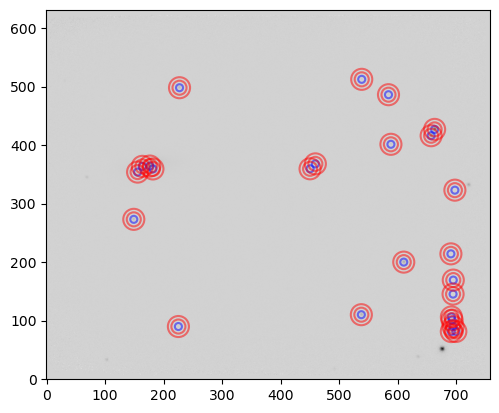

C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data
C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


        X                  Y          ...       mag_error      
------------------ ------------------ ... ---------------------
 691.9883853825537  81.08730127940592 ...   -0.5680389407572335
 699.7126039010519  81.24885079695464 ...   -0.7377785560475852
225.30291679956574  89.69707287911123 ...   0.15394567940516388
  694.998151646689  89.53363821316161 ...   -0.8441154983735154
 693.3481945409883 100.69266742679334 ...     4.701610053512352
  692.101528413218 106.01550229022405 ...     8.780632131336748
 538.1169064456011 109.94181998933378 ...  0.015997440373337238
 694.9814460917304  145.1471406112754 ...     -7.03219739436781
 695.3276265896533 169.11356557871744 ...    13.679774588383184
 610.6578124762257 199.83744343585965 ...  0.010514233734866034
               ...                ... ...                   ...
181.72561378342417  359.1232762386476 ...  0.029705435237857052
 450.4358710426781  359.4109458737506 ...  0.020332415887692516
 163.6400451533947 363.58212828351634 ..

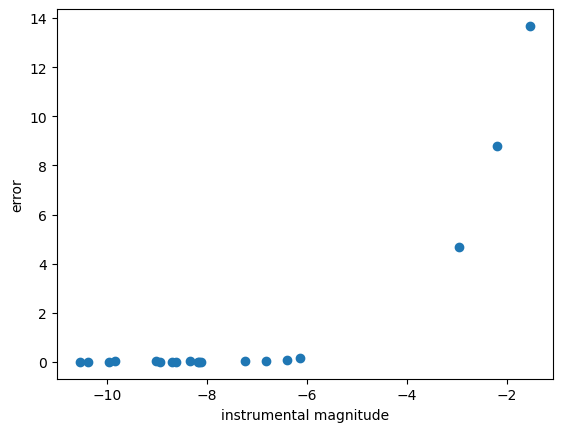

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Number of results: 44


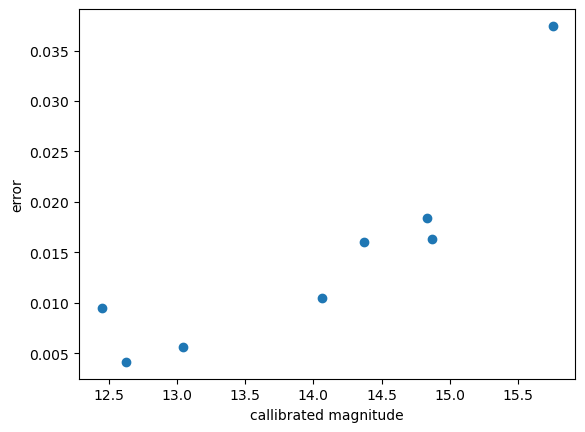

C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(23.00477344095993,
 0.21361741270439025,
 17.332003146099147,
 0.11165074661384224)

In [86]:
AvgZP("new-image-2", 6, 0.52, "H")

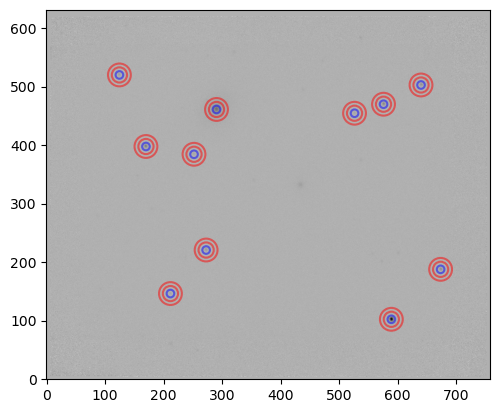

C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


        X                  Y          ...      mag_error      
------------------ ------------------ ... --------------------
 589.4430343955542 102.06179006655756 ... 0.005304439038365466
211.70853447442377 146.08125963865288 ...  0.11315149457580596
 673.6780207710689 187.48733714938876 ...  0.03626073406635218
272.72774312757446 220.51511020998115 ... 0.045741019592333225
251.99200335458755  384.2381631058047 ...   0.0932212077795075
169.81247969790368  397.5465309947364 ... 0.017268286073445167
 526.5050733356795  454.4191598782922 ...  0.13588544734322072
  290.465381407756 460.87838235597127 ...   0.0085024022546568
 576.0624181758533  469.8378281466203 ... 0.023355237137718754
 640.1626665011879 502.72182906616786 ...  0.03731812575489025
124.43933523497539   519.908614511647 ...  0.06734570869764683


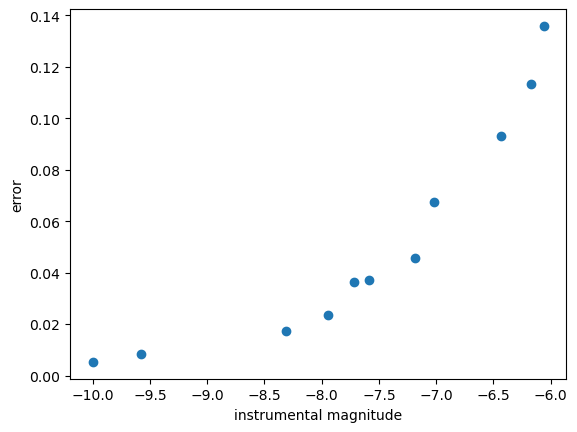

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Number of results: 50


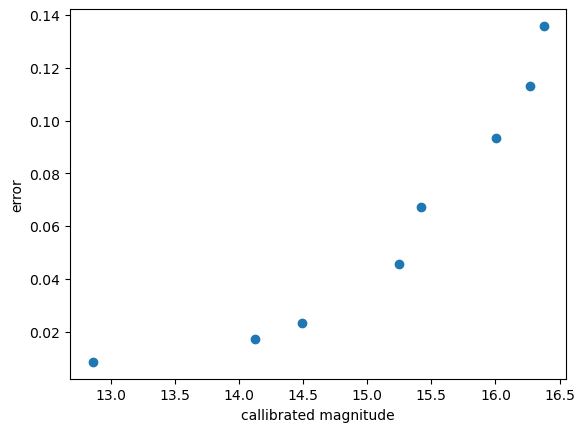

C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(22.437074725419738,
 0.08425846623483199,
 16.620439571499055,
 0.33284503501250345)

In [87]:
AvgZP("new-image-3", 6.5, 0.52, "J")

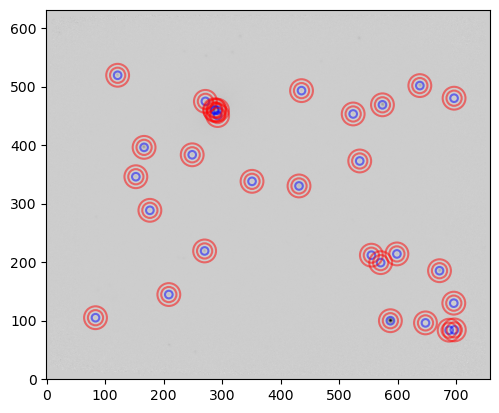

C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data
C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


        X                  Y          ...       mag_error      
------------------ ------------------ ... ---------------------
 688.2621572144263  83.42814164073026 ...    1.0858202036417393
 697.1358920954743  83.90331950923812 ...    14.319077573418108
 647.8119435046036  95.91607070761188 ...   -2.1406822902364917
 587.8110982450623    99.644915720789 ... 0.0021684445010225375
 83.56526439020541 104.78479350222307 ...   0.12705059957484718
 696.2156603975085 129.64837636101328 ...   -5.1974521711822375
208.94303862109555 144.38346163378358 ...   0.03591319508121135
 671.7978183114698 185.16697509425435 ...   0.01503969306351233
 571.1821089072308 198.95103951418784 ...   0.05259384439218654
 555.2808030323818 211.69170286708962 ...   0.08681728358083891
               ...                ... ...                   ...
 292.4054423315263  450.4424379427916 ...   0.03753275646271296
 524.1694698075293 453.16279439303736 ...  0.051097373947261215
288.04452228177206 458.91988213057033 ..

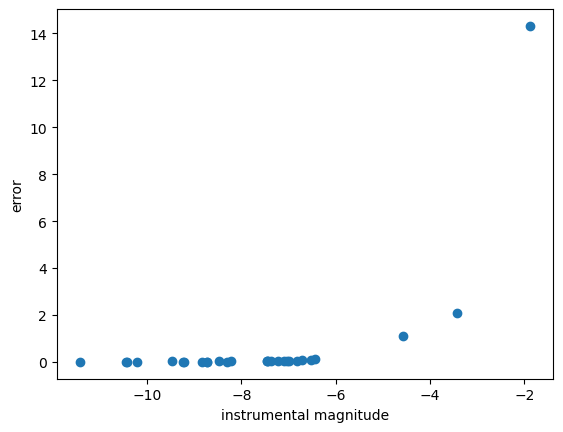

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Number of results: 48


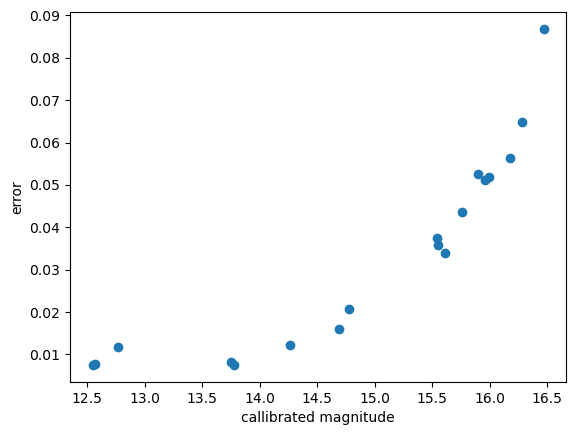

C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(22.98836926340238,
 0.3451092388011188,
 17.339525370343416,
 0.17440127224039417)

In [88]:
AvgZP("new-image-4", 6.5, 0.52, "H")

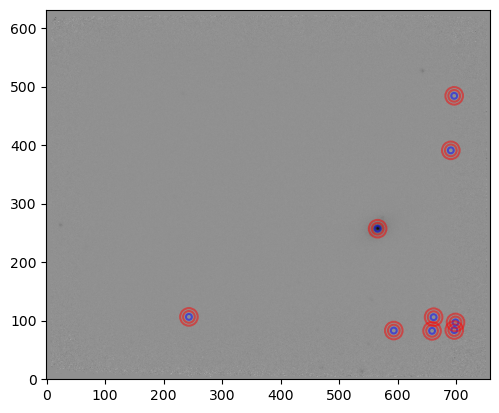

        X                  Y          ...      mag_error      
------------------ ------------------ ... --------------------
  659.044950059214  82.29318531327966 ...   2.6068462803796217
 593.6075298358828  82.80600282981942 ...  0.36667378738519213
 697.0162063346453  83.67775987497521 ...   0.7089021509869503
 699.1683823037854  96.72114718070709 ...   0.5906884644198449
243.30077215557918 106.17441753900658 ...     6.16495341848054
 661.7036004566569 105.71796456271339 ...  -0.6786480703886203
 565.9771291659713 257.00610154863074 ... 0.008741606284247654
 691.0940963106766 390.95123872895687 ...   -3.889187034361312
 696.8880367931642 484.16937974595777 ...   0.5314963963462912


C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data
C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


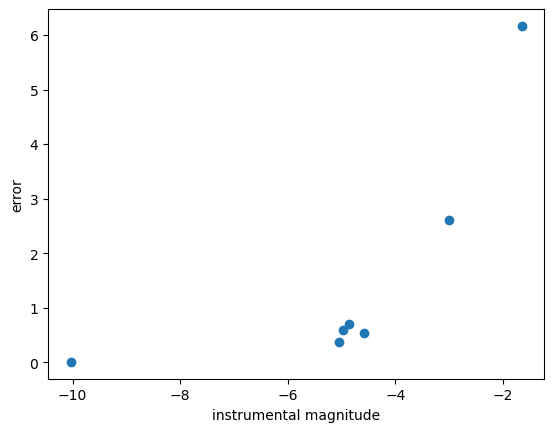

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Number of results: 46


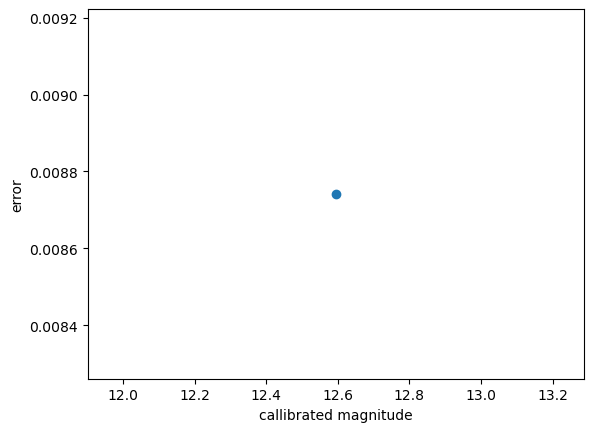

C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(22.63187143647194, 0.0, 17.277514159011286, 0.10644519476412469)

In [89]:
AvgZP("new-image-5", 5, 0.52, "H")

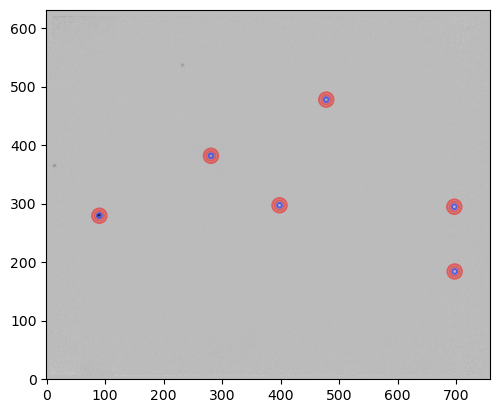

        X                  Y          ...       mag_error      
------------------ ------------------ ... ---------------------
 697.7253042438136  183.8409666364525 ...     1.819194745552629
 90.07614014393947  279.1632367533343 ... 0.0034782934661894875
 697.0943444836471 294.54849375489437 ...  -0.29849162305892785
  398.204741410944  297.0280909429172 ...   0.06638677358461104
 280.9523163506334 381.66298219114674 ...  0.015437550540333626
478.13076081942506  477.7281808248335 ...  0.029242854132093914


C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data
C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


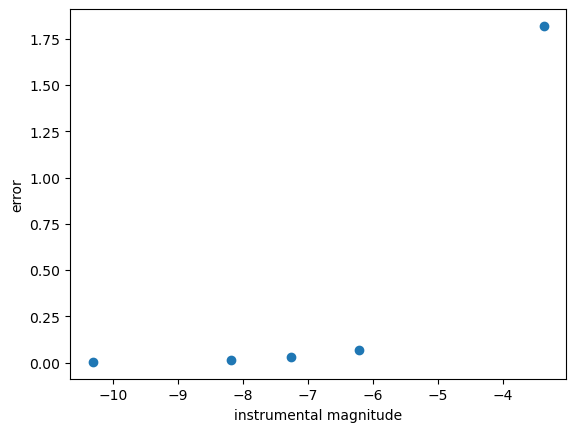

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Number of results: 49


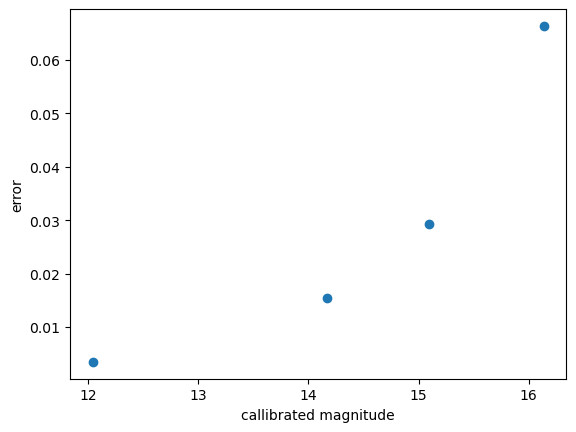

C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(22.35557668734276, 0.24063531246234682, 17.05732616517163, 0.1496923605229751)

In [94]:
AvgZP("new-image-6", 4.1, 0.52, "J")

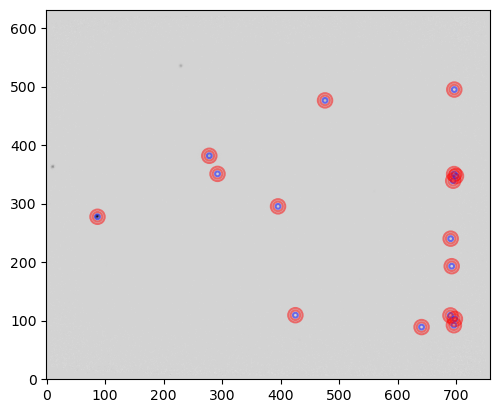

        X                  Y          ...       mag_error      
------------------ ------------------ ... ---------------------
 641.1187989744413  88.76333003167325 ...    -6.193224917281829
 696.3861600547107  91.93098976740457 ...  -0.32524393387542344
 698.1279151611847 102.69763640805485 ...    3.5814757722135036
425.36027419008406 109.08578894500963 ...   -1.4201676538000116
 690.4872911193745 108.73131628282977 ...   -5.0659314413382805
  692.641527496667  192.8702036194986 ...    2.6235739631249935
 690.8660151355963 239.96190690029567 ...   0.08375896359057967
 86.97494454680265 277.37448900752804 ... 0.0021186150431672765
 395.6818108281216  295.1803817202486 ...  0.024656346388155538
 695.1889540152375 339.01010385817534 ...     1.790638219907317
 699.9665753158905  347.0805837139435 ...    3.4819219643858155
 696.7411742519124  350.4423001798706 ...     1.129717486586876
  292.207131496341 350.71213927652263 ...   0.04547978665359237
278.14084788545824 381.66965237664135 ..

C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data
C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


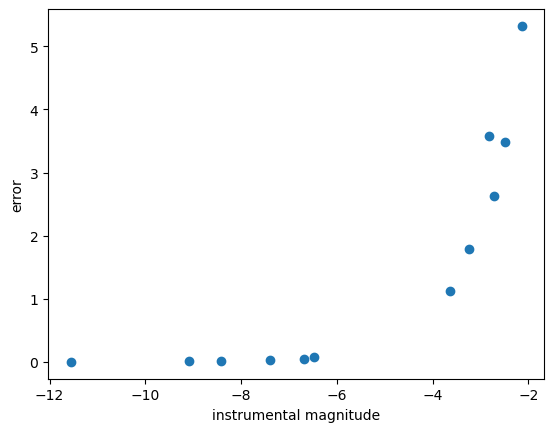

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Number of results: 50


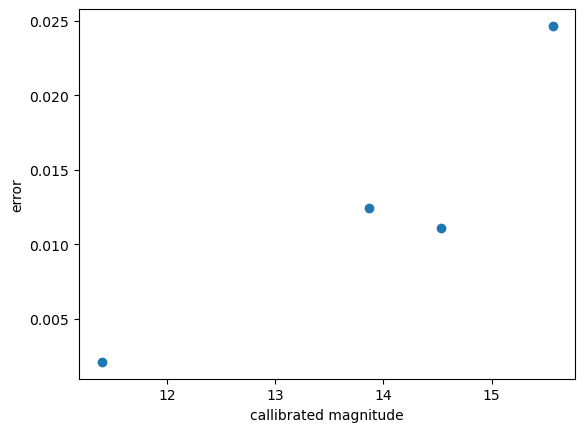

C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(22.95530058093804,
 0.021529500910409914,
 17.694070688302027,
 0.10344132468172872)

In [95]:
AvgZP("new-image-7", 4.1, 0.52, "H")

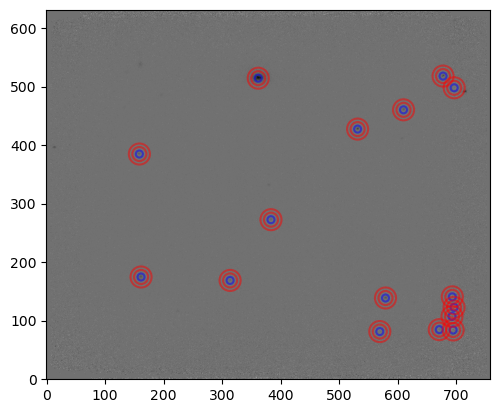

C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data
C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


        X                  Y          ...      mag_error      
------------------ ------------------ ... --------------------
 569.6539459952149  81.09556616206201 ...   1.7587864323596483
 671.4080094962966  84.41159393627534 ...   13.566727723446844
 695.1260480855906   83.7972979249836 ...   1.7097541619236831
 693.1590568046635  107.0643177833172 ...  -1.1280695913432954
 696.6594742867552 122.41860584811586 ...  -0.6046938574259326
 579.4484465826353   138.459975191283 ...  0.06974115868618028
 693.6974332656305 140.46946622570823 ...   1.1492267530557723
313.72118911063274 168.54508649486775 ...  0.11749821660663899
161.44121174190124  174.4069900084811 ... 0.028688029009181982
383.60448908128103 272.42220147828687 ...  0.13713011720380983
158.56036423339052  384.6695052487596 ...  0.07099804381067057
  531.767612467544 427.30710399045415 ... 0.037317329926206705
 610.2603075055218  460.2608935064429 ...  0.06397292876676795
 696.8752827929633  497.9199879439113 ...  -1.071793114

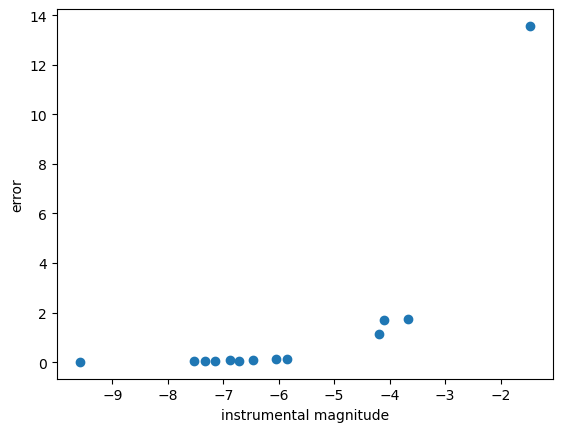

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Number of results: 48


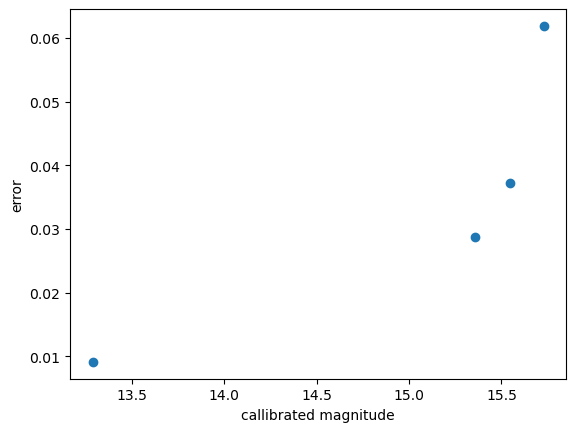

C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(22.878238137098396,
 0.3143432901979563,
 17.260048584860698,
 0.21183667575765186)

In [100]:
AvgZP("new-image-8", 6, 0.52, "H")

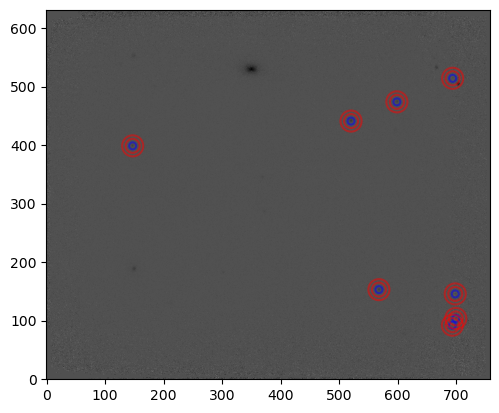

C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data
C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


        X                  Y          ...      mag_error      
------------------ ------------------ ... --------------------
 693.8700723641099  91.98606463246308 ...   1.4189340545641398
 699.6257246088554 103.51944292113643 ...  -2.3883995580477944
 698.6972160745553  145.4476111510954 ...   0.6503646594317359
 568.1772612745515  152.7984190776913 ...  0.08462524498044963
147.11491122773938 398.63626789767517 ...  0.09923443564504553
 520.4972721791241 441.03666491407546 ... 0.050735956977857315
 598.9071263833945 473.87163511097685 ...  0.07107939389619157
 694.2757371597125  514.1517435445445 ...   2.0007341924914743


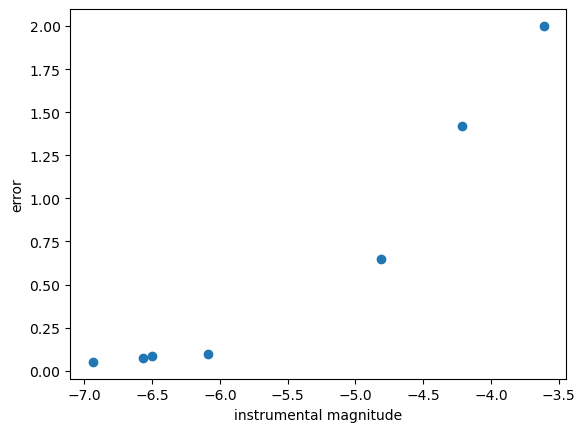

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Number of results: 48


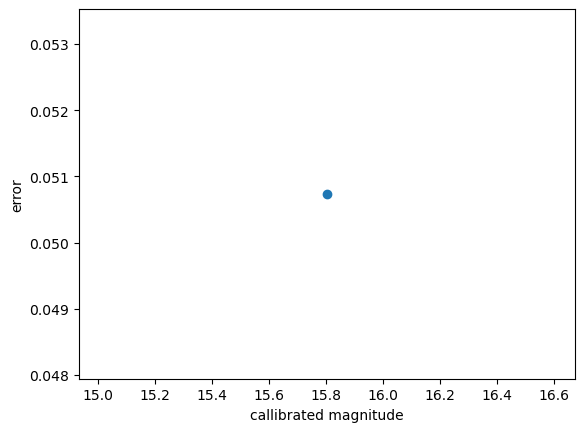

C:\Users\ranvi\AppData\Local\Temp\ipykernel_20556\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(22.742442543547448, 0.0, 17.19764457132331, 0.07979850251877041)

In [101]:
AvgZP("new-image-9", 6, 0.52, "H")

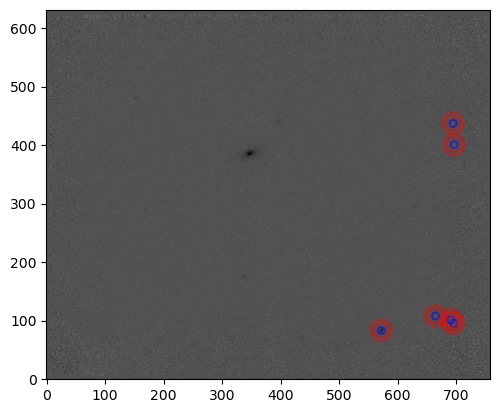

        X                 Y          ...      mag_error      
----------------- ------------------ ... --------------------
572.3783078168588  82.84315564519792 ...   0.0406437839735328
696.2355195051726  94.98403672495434 ...   0.4679389737077458
691.1497560986651 101.11180162257217 ...  0.28756655294529937
664.9904729191189 107.64929515474714 ...   0.6083592002217199
 696.931549181918 400.80437898250295 ... -0.39279135386582836
695.0808250956021 436.95070546610447 ...   0.6079567452449467


C:\Users\ranvi\AppData\Local\Temp\ipykernel_7896\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data
C:\Users\ranvi\AppData\Local\Temp\ipykernel_7896\3476141969.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


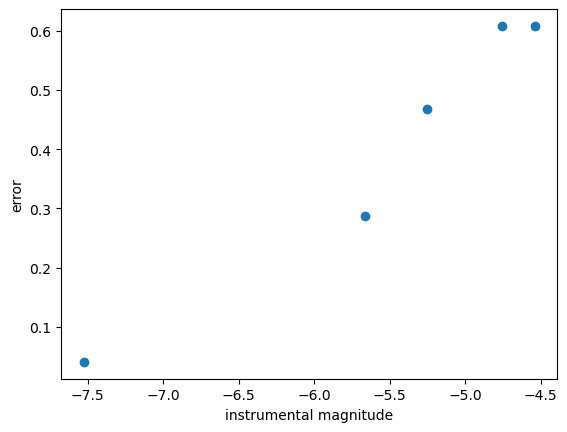

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Number of results: 50


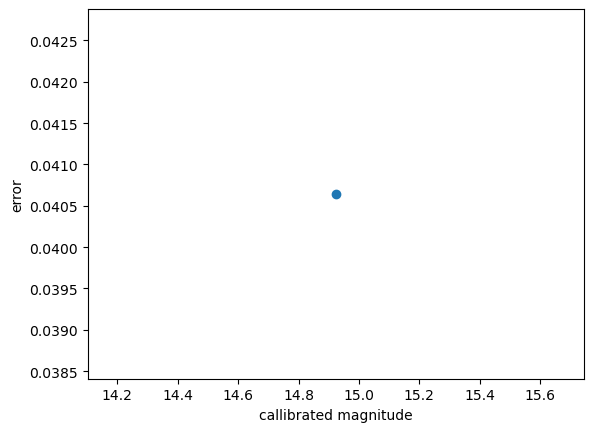

C:\Users\ranvi\AppData\Local\Temp\ipykernel_7896\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(22.44792708155295, 0.0, 16.873382005771752, 0.13156817381050914)

In [4]:
AvgZP("new-image-10", 6, 0.52, "J")

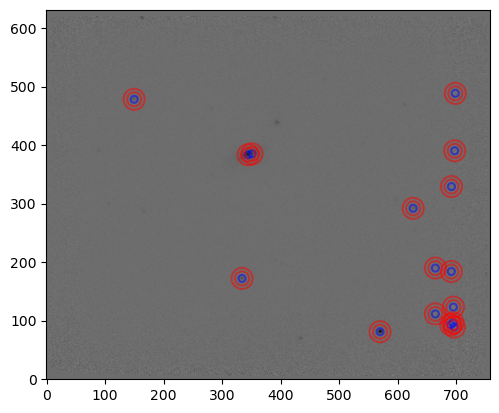

        X                  Y          ...      mag_error      
------------------ ------------------ ... --------------------
 570.0977186477878  80.80707981516153 ... 0.013483708272015796
 697.1321017179839  88.75107682226295 ...   1.6762383168627066
 691.0888960761998    92.694396018892 ...  0.19201804181572965
 694.9907651431815  95.92434608890623 ...   10.526927893137723
 664.6443293541678 111.22919340654317 ...    1.247020584996524
 695.5364415717216 122.89393556529669 ...  -0.8730503106730956
 334.1244697274897    171.92492607194 ...  0.03600456406045099
 692.0355420987397 183.77818155707033 ...   -6.424910748445703
 664.7385414979385 189.64739257612024 ...    -0.38313992293605
 626.7409973299848 291.82102032924854 ...  0.06433081373193068
 692.2186495222309  329.0118974126828 ...   1.2825795430792553
344.50982456903654 383.41644076280323 ... 0.013671138889238953
 351.1622454873939  385.0195644664972 ... 0.015786080709261997
 697.7648529283317  390.2031015282154 ...     3.1223959

C:\Users\ranvi\AppData\Local\Temp\ipykernel_7896\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data
C:\Users\ranvi\AppData\Local\Temp\ipykernel_7896\3476141969.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


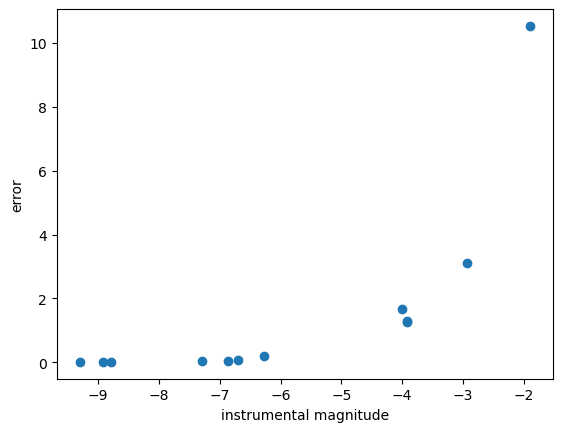

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Number of results: 48


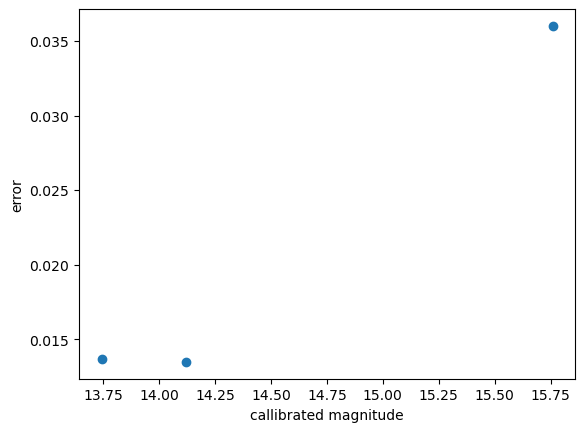

C:\Users\ranvi\AppData\Local\Temp\ipykernel_7896\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(23.047740414216957, 0.5974702908664317, 17.463455242511, 0.21352855188722988)

In [7]:
AvgZP("new-image-11", 6, 0.52, "H")

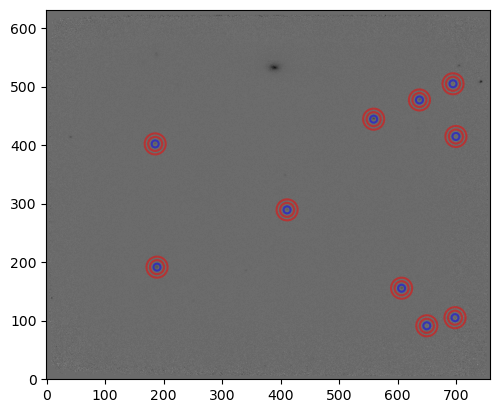

        X                  Y          ...      mag_error     
------------------ ------------------ ... -------------------
 650.0775940270472   90.9735842941999 ...  1.7882712939520262
 698.3036265826651 104.82390124766742 ...  1.6188030319416433
 606.9541737616512 155.21545645497798 ... 0.06398879190451391
188.72847918676268 191.23314302542192 ... 0.02755003957266116
411.17083451762494   289.210389654535 ...  0.1910446721699796
 185.6063833325651 401.96249266274987 ... 0.06344828776603814
  699.863929175316 414.66794459243636 ...  1.5566690540884676
 559.1874357743657  444.2843038995093 ... 0.04264346580280771
  637.472637791738  477.1145788566436 ... 0.07463648093004466
 694.8848598104545 504.77665820537067 ... -1.2801081552824845


C:\Users\ranvi\AppData\Local\Temp\ipykernel_7896\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data
C:\Users\ranvi\AppData\Local\Temp\ipykernel_7896\3476141969.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


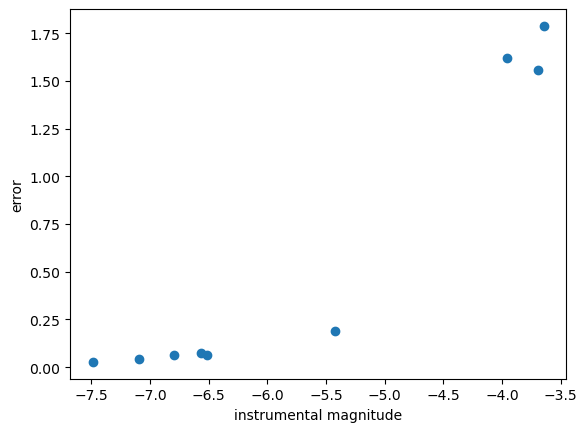

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Number of results: 48


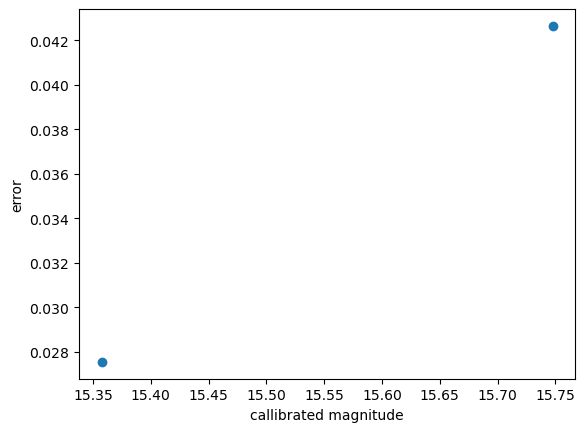

C:\Users\ranvi\AppData\Local\Temp\ipykernel_7896\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(22.84456801472856,
 0.08373551498757835,
 17.312999136371893,
 0.17353606105610841)

In [8]:
AvgZP("new-image-12", 6, 0.52, "H")

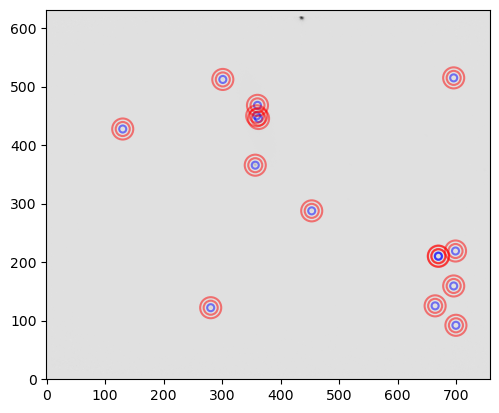

C:\Users\ranvi\AppData\Local\Temp\ipykernel_28756\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data
C:\Users\ranvi\AppData\Local\Temp\ipykernel_28756\3476141969.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


        X                  Y          ...      mag_error      
------------------ ------------------ ... --------------------
 699.8531602020126  91.79556007488287 ...   0.9260026582989132
280.53618686713514 121.88311156236608 ... 0.015045507751330485
 664.3024001259247 125.06114871576429 ...   0.8629387386829426
 696.0473806271257  159.0616108760916 ...   0.8630835435489864
 670.0891213293687 209.68340741527288 ...  0.01882194821276371
 669.6575536119518 210.23455162999252 ...  0.01882105016651782
 699.1744428666498 218.83386521058125 ...   -1.336864752950247
  453.272752457057 287.49125604516394 ... 0.015060628403475928
 356.7298949410956  365.5748525676253 ... 0.003896436803001316
130.11002952909877  427.4451703656563 ...  0.09277820813039254
 362.3806093839339 445.41203194804865 ... 0.016129086192806792
359.17502433024697  450.0071374397472 ... 0.009658369038898487
360.54160498246887  467.8888785106394 ...  0.04686267579452597
 301.2370630540754  512.2029264179249 ... 0.01585678707

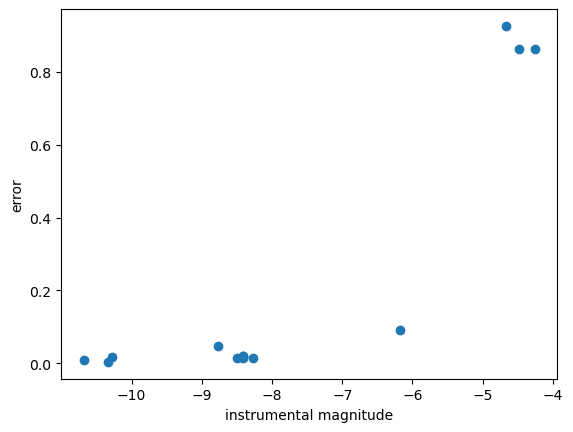

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Number of results: 48


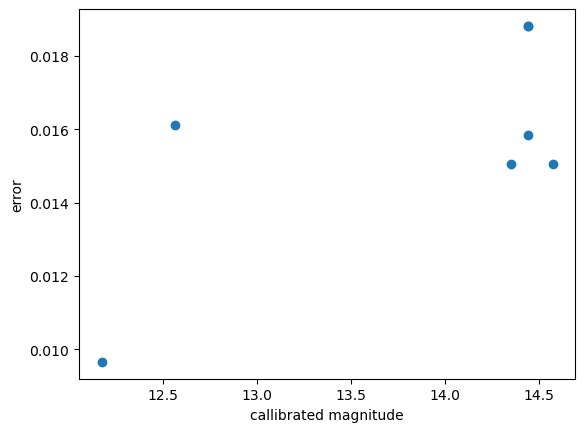

C:\Users\ranvi\AppData\Local\Temp\ipykernel_28756\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(22.85014297163799, 0.09677970464987712, 17.280903247791926, 0.267070659432758)

In [4]:
AvgZP("new-image-13", 6, 0.52, "H")

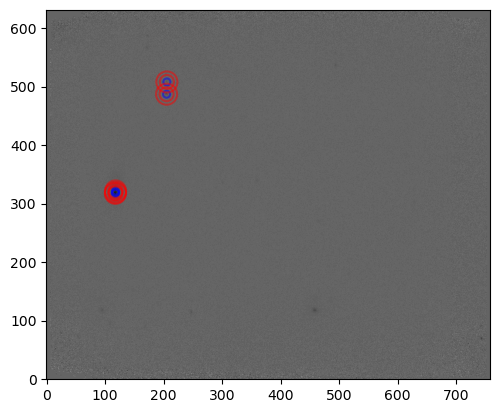

C:\Users\ranvi\AppData\Local\Temp\ipykernel_28756\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


        X                  Y          ...      mag_error      
------------------ ------------------ ... --------------------
117.51624750163701  317.4085378266863 ... 0.011812039333511229
117.80319626396856 318.84542290691127 ...  0.01161435316172376
117.85518262477069 321.58128129264765 ... 0.013149143722399089
205.10490208101055  487.0002074462243 ... 0.050493620384454575
 205.6070755096007  507.8790749174059 ...  0.12508729429228213


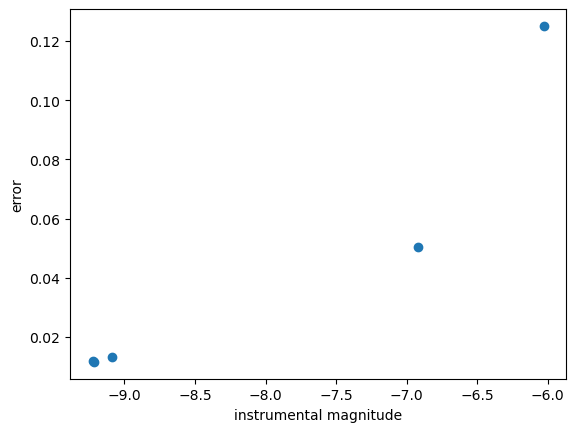

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Number of results: 48


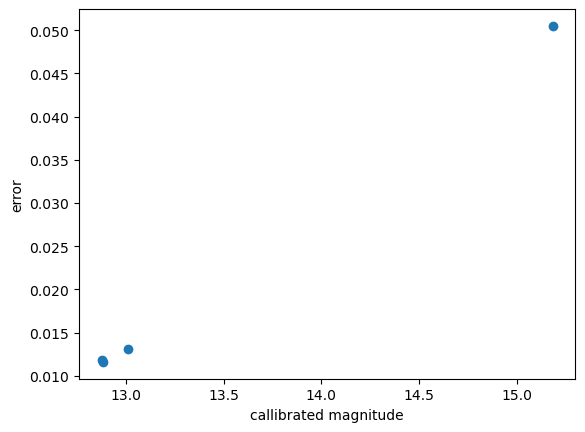

C:\Users\ranvi\AppData\Local\Temp\ipykernel_28756\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(22.1021973364287, 0.09854614421673527, 16.49405380410012, 0.16541740112386796)

In [5]:
AvgZP("new-image-14", 6, 0.52, "H")

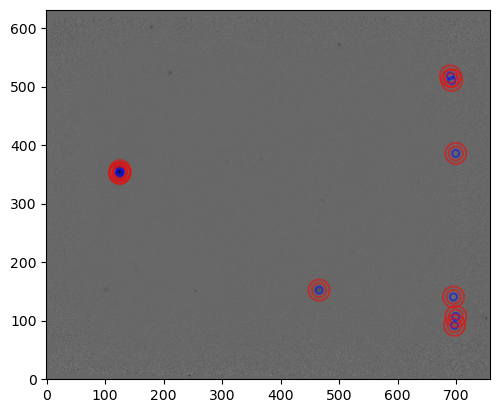

C:\Users\ranvi\AppData\Local\Temp\ipykernel_28756\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data
C:\Users\ranvi\AppData\Local\Temp\ipykernel_28756\3476141969.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


        X                  Y          ...      mag_error      
------------------ ------------------ ... --------------------
 697.4309624614593  91.75842928752189 ...   0.6489136697710489
 699.6519187937356 106.64738726289836 ...   -0.567089835428492
 695.7343823078941 140.30230150739956 ...  -1.2368153972722324
465.85930310914495  151.9276449591329 ...  0.02824752086092095
124.56391066747737  351.2868426196414 ... 0.009518979447171819
125.16478309918037 352.65915086313396 ... 0.009534440871632178
125.65846632526102 356.29462755531506 ... 0.010870043052083424
  699.636838502257  385.6394665904155 ...   0.7070891011576034
 692.7247190027954  510.4534958419906 ...  0.41174948953430357
 690.3470633038071   518.241784997814 ...   0.9660988133138518


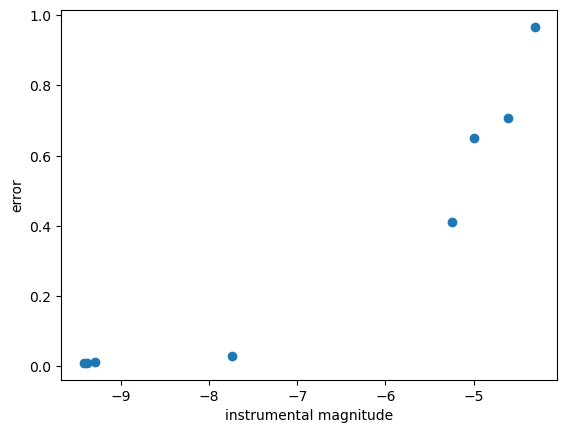

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Number of results: 48


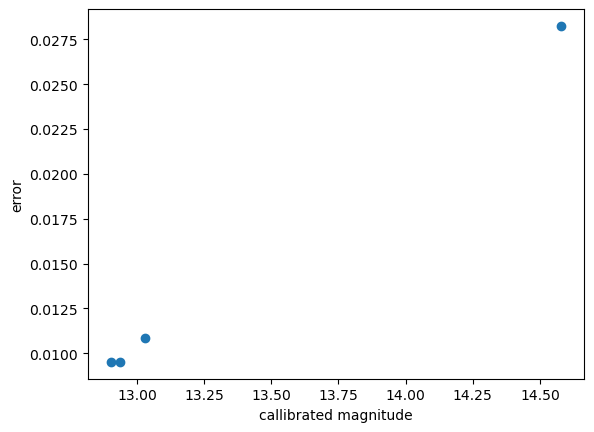

C:\Users\ranvi\AppData\Local\Temp\ipykernel_28756\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(22.323963397038703,
 0.09495448585753219,
 16.728741062948128,
 0.3062195704493563)

In [6]:
AvgZP("new-image-15", 6, 0.52, "H")

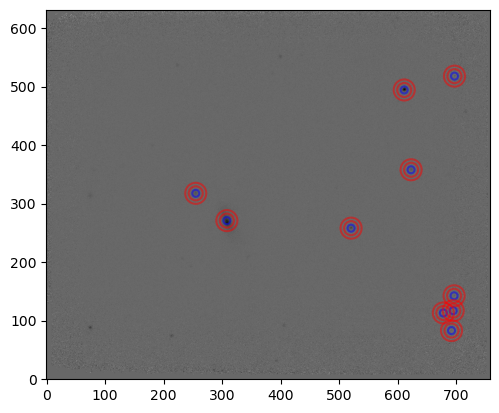

C:\Users\ranvi\AppData\Local\Temp\ipykernel_28756\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data
C:\Users\ranvi\AppData\Local\Temp\ipykernel_28756\3476141969.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


        X                  Y          ...      mag_error      
------------------ ------------------ ... --------------------
 692.2903099826236  82.80377045079027 ...  -0.8831178250671393
 678.3626121736269 112.89508419634225 ...   2.7659345655782204
 695.2367327780715 116.81431386426387 ...   1.4100234914739564
  696.712975098296 142.22391477390593 ...   1.6012221594121787
 520.5757255339171 257.89453593983177 ... 0.033911199936589684
  308.151788820249 270.81426785017555 ... 0.013975712913881293
254.97581447702655  317.4608609906383 ... 0.028763095760341733
 623.1625232746392  357.7767125071214 ...  0.06790228786194143
 611.4408602829574  494.2203466058832 ... 0.011573376781841189
 697.3851360845724  517.8470838903111 ...   0.7411433246086441


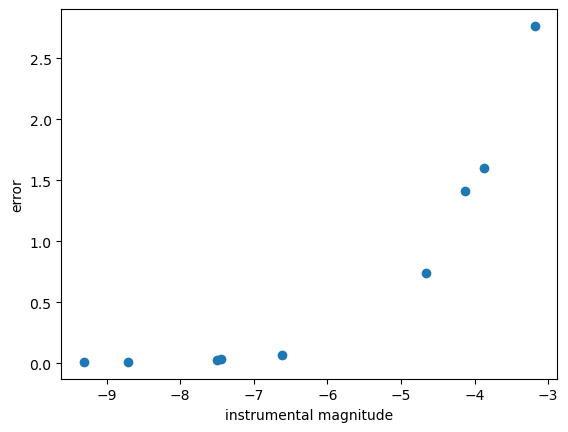

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Number of results: 48


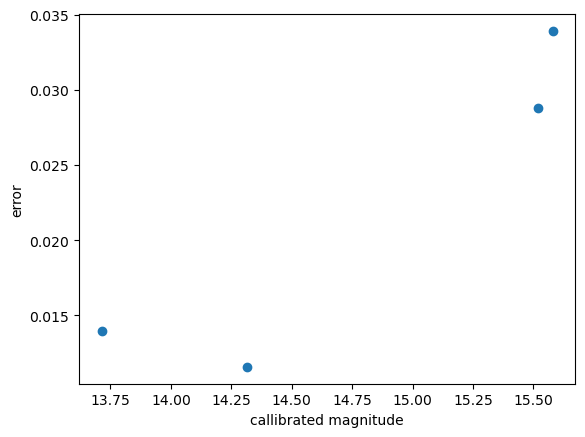

C:\Users\ranvi\AppData\Local\Temp\ipykernel_28756\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(23.020469707561087,
 0.2090267864803673,
 17.460256645706608,
 0.12429680127438708)

In [9]:
AvgZP("new-image-16", 6, 0.52, "H")

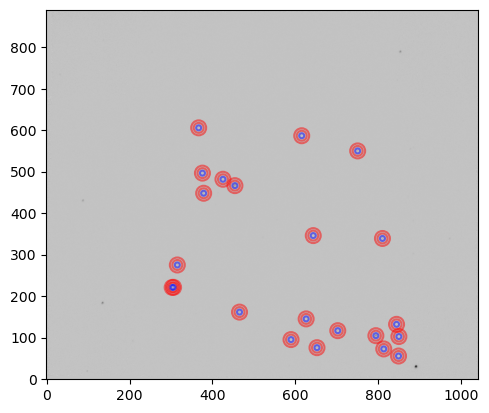

C:\Users\ranvi\AppData\Local\Temp\ipykernel_28756\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


        X                  Y          ...       mag_error      
------------------ ------------------ ... ---------------------
 848.5502786261691  55.55790760891104 ...   0.34425505401538553
 812.9072787110914  72.64572125961146 ...   0.07223162853664206
 651.9429791168438  75.68745009996927 ...   0.06127596624166216
 589.3230164641591  95.17934505150642 ...   0.12805468992982388
 849.3397393161347 102.55333096447384 ...    1.0670762544034629
 793.8956455663055 104.62803625154868 ...  0.013574530552921401
 702.0172400315453 116.68305716756156 ...   0.06940039357657045
 843.7532369490418 131.94267542155424 ...   0.27034178760492134
 625.7948916601438 145.06684303080777 ...   0.17071295540367576
465.19519071996336  161.4347878869368 ...   0.04711160464729945
 302.8386400343082  220.9638371833947 ...   0.02514847294256684
 306.2498785608209 221.17003105728458 ...   0.02732976757469712
   315.24246794649  275.0520091309586 ...   0.04118757391427973
 809.7674739137034  338.9856064309369 ..

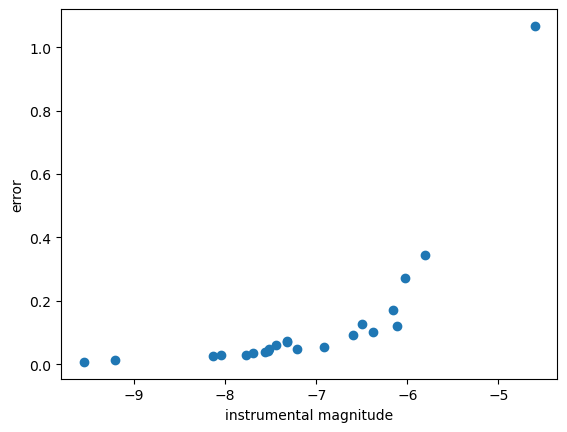

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Number of results: 49


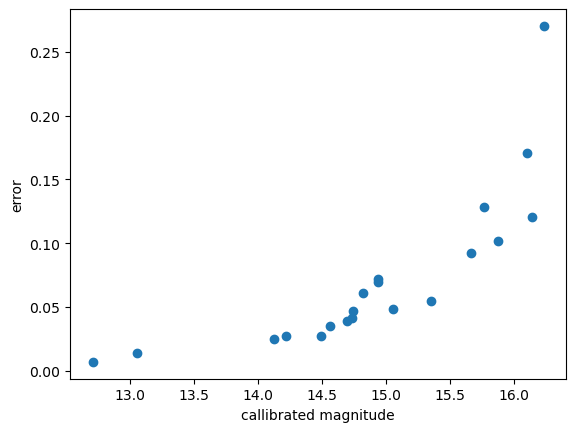

C:\Users\ranvi\AppData\Local\Temp\ipykernel_28756\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(22.262888657867343,
 0.16927882705838496,
 16.294657216391506,
 0.3280437211476395)

In [15]:
AvgZP("new-image-17", 6, 0.52, "J")

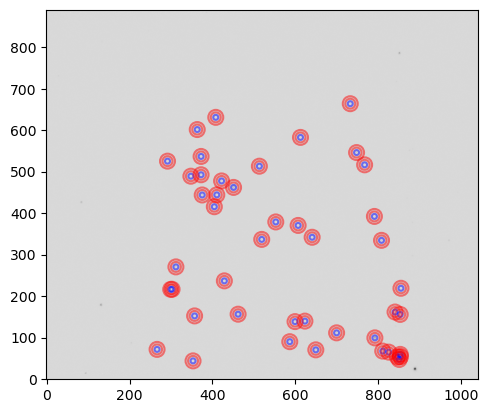

C:\Users\ranvi\AppData\Local\Temp\ipykernel_28756\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data
C:\Users\ranvi\AppData\Local\Temp\ipykernel_28756\3476141969.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


        X                  Y          ...      mag_error      
------------------ ------------------ ... --------------------
353.14690519867287   43.8613950201727 ...   0.7582359013207676
 850.1422867174458 47.263048223769616 ...    7.600448479312928
 845.8969470923865   53.2085528065628 ...    231.1298059382991
 853.2988844679186  53.98226612279882 ...  -11.792112922780548
 852.6585497895296  59.54192424035195 ...   0.5377493159618448
 824.8701006204493  64.94184014784938 ...  -0.7607153989323622
 810.4532833040568  67.42997803076493 ... 0.028348954649207992
 649.1039521285321  70.45878166765971 ... 0.020419571699131004
 266.4476335973723  71.55784116347398 ...  0.21718547905649274
  586.321736904594  90.12241404451134 ...  0.03977421934731508
               ...                ... ...                  ...
347.92647267021727  489.0619790350702 ...   0.1112113610071944
372.51235050751075  492.5322970721159 ... 0.016119509233954176
 513.0541789229848  513.1851232328506 ...  0.1106460824

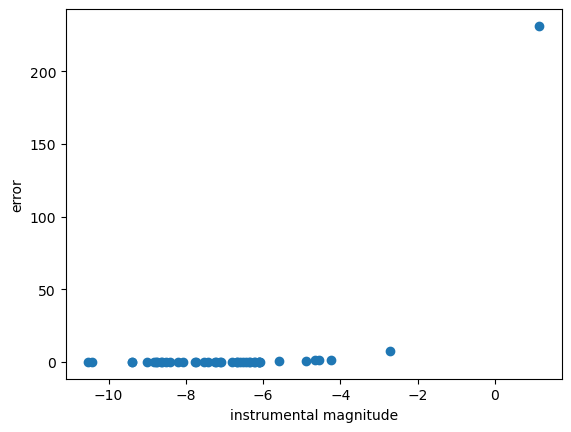

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Number of results: 47


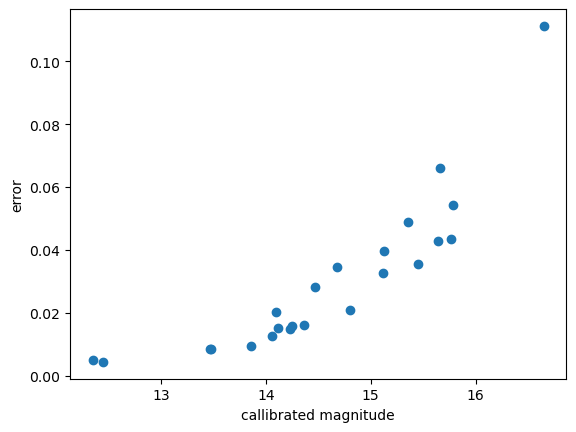

C:\Users\ranvi\AppData\Local\Temp\ipykernel_28756\3476141969.py:42: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data


(22.871322347302588,
 0.2167117615892671,
 17.047559530922953,
 0.2770370361198787)

In [14]:
AvgZP("new-image-18", 6, 0.52, "H")

In [5]:
print(coordinates.SkyCoord(ra = '05:52:19', dec = '+32:32:44', unit = (u.hourangle, u.degree)))

<SkyCoord (ICRS): (ra, dec) in deg
    (88.07916667, 32.54555556)>
